# Overview SLEAP tracking pipeline in common world coords

## Import modules

In [1]:
import os
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

## constants

In [2]:
VIDEO_ID = 0
SAVE_FIG = False
SAVE_FIG_FORMAT = "pdf"
SAVE_FIG_DIR = (
    f"/home/csk/Documents/Research/Modeling singing mouse behavior/plots/{VIDEO_ID}"
)
COMMON_WORLD_COORDS_FILEPATH = f"/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_video/2023-09-20-100934_cam0_0000{VIDEO_ID}.common_coords.mat"
L_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21415940_corrected.yml"
R_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21428187_corrected.yml"

## load tracking file and skeleton

In [3]:
# load world coords
locations_world = scipy.io.loadmat(COMMON_WORLD_COORDS_FILEPATH, squeeze_me=True)
l_locations_world = locations_world["l_locations_world"]
r_locations_world = locations_world["r_locations_world"]
fps = 50

In [4]:
with open(L_COORDS_FILEPATH, "r") as f:
    l_coords = yaml.safe_load(f)
l_coords_world = l_coords["world_cage"]
with open(R_COORDS_FILEPATH, "r") as f:
    r_coords = yaml.safe_load(f)
r_coords_world = r_coords["world_cage"]

In [5]:
skeleton = np.array([[2, 0], [2, 1], [0, 1], [2, 3], [3, 4], [4, 5]])

## plot first frame for sanity check

In [6]:
def plot_skeleton(ax, location_frame, skeleton, color):
    xs = location_frame[:, 0].astype(int)
    ys = location_frame[:, 1].astype(int)

    # plot joints
    for i_joint in range(skeleton.shape[0]):
        index1, index2 = skeleton[i_joint, 0], skeleton[i_joint, 1]
        ax.plot(
            [xs[index1], xs[index2]],
            [ys[index1], ys[index2]],
            color=tuple(c / 255 for c in color),
            linewidth=2,
            linestyle="-",
        )

    # plot points
    for j in range(location_frame.shape[0]):
        ax.add_patch(patches.Circle([xs[j], ys[j]], radius=2, color="w", zorder=2))

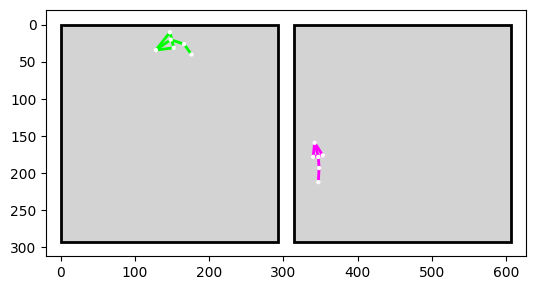

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.add_patch(
    patches.Rectangle(
        (l_coords_world["x"], l_coords_world["y"]),
        l_coords_world["w"],
        l_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="lightgray",
    )
)
ax.add_patch(
    patches.Rectangle(
        (r_coords_world["x"], r_coords_world["y"]),
        r_coords_world["w"],
        r_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="lightgray",
    )
)
ax.invert_yaxis()
ax.set_xlim([-20, 627])
ax.set_ylim([312, -20])
ax.set_aspect("equal", adjustable="box")
plot_skeleton(ax, l_locations_world[0, :, :], skeleton, (0, 255, 0))
plot_skeleton(ax, r_locations_world[0, :, :], skeleton, (255, 0, 255))
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__position_sanity_check.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

## plot activity spatial overview

In [8]:
spineM_idx = 4
l_spineM_world = l_locations_world[:,spineM_idx,:]
r_spineM_world = r_locations_world[:,spineM_idx,:]

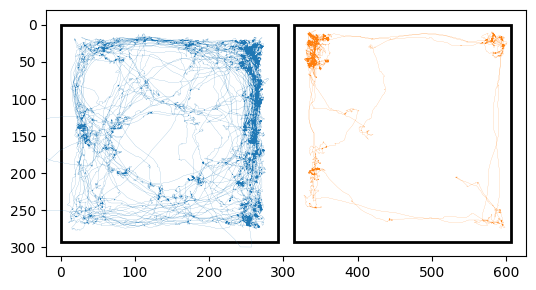

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.add_patch(
    patches.Rectangle(
        (l_coords_world["x"], l_coords_world["y"]),
        l_coords_world["w"],
        l_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.add_patch(
    patches.Rectangle(
        (r_coords_world["x"], r_coords_world["y"]),
        r_coords_world["w"],
        r_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.invert_yaxis()
ax.set_xlim([-20, 627])
ax.set_ylim([312, -20])
ax.set_aspect("equal", adjustable="box")
ax.plot(l_spineM_world[:, 0], l_spineM_world[:, 1], linewidth=0.1)
ax.plot(r_spineM_world[:, 0], r_spineM_world[:, 1], linewidth=0.1)
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__position.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

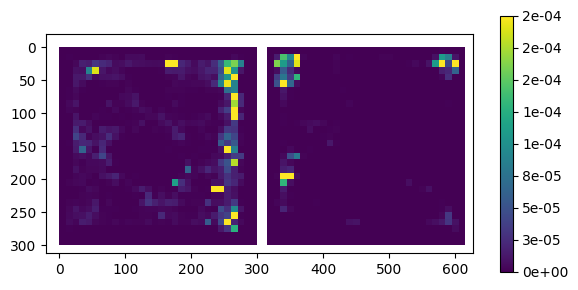

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))
bin_size = 10
vmin = 0
vmax = 0.0002
l_x_edges = np.arange(
    l_coords_world["x"], l_coords_world["x"] + l_coords_world["w"] + bin_size, bin_size
)
l_y_edges = np.arange(
    l_coords_world["y"], l_coords_world["y"] + l_coords_world["h"] + bin_size, bin_size
)
r_x_edges = np.arange(
    r_coords_world["x"], r_coords_world["x"] + r_coords_world["w"] + bin_size, bin_size
)
r_y_edges = np.arange(
    r_coords_world["y"], r_coords_world["y"] + r_coords_world["h"] + bin_size, bin_size
)
l_heatmap = ax.hist2d(
    l_spineM_world[:, 0],
    l_spineM_world[:, 1],
    bins=(l_x_edges, l_y_edges),
    density=True,
    vmin=vmin,
    vmax=vmax,
)
r_heatmap = ax.hist2d(
    r_spineM_world[:, 0],
    r_spineM_world[:, 1],
    bins=(r_x_edges, r_y_edges),
    density=True,
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlim([-20, 627])
ax.set_ylim([312, -20])
ax.set_aspect("equal", adjustable="box")
fig.colorbar(r_heatmap[3], ax=ax, format="%.e")
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__heatmap.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

## plot activity temporal overview

In [11]:
session_duration = l_locations_world.shape[0]/fps
t = np.arange(0, session_duration, 1/fps)

In [12]:
l_spineM_xs_world = l_spineM_world[:,0]
l_spineM_ys_world = l_spineM_world[:,1]
r_spineM_xs_world = r_spineM_world[:,0]
r_spineM_ys_world = r_spineM_world[:,1]

distance = np.sqrt(np.square(l_spineM_xs_world-r_spineM_xs_world) + np.square(l_spineM_ys_world-r_spineM_ys_world))

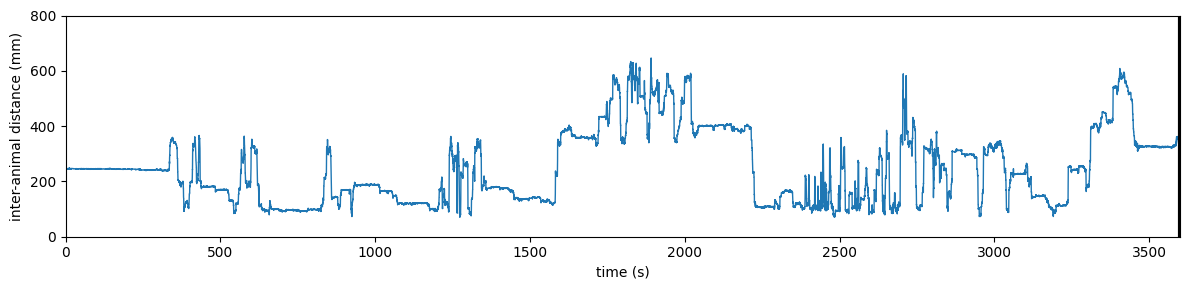

In [13]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, distance, linewidth=1)
ax.axvline(3600, color="k", linewidth=3)
ax.set_xlim([0, session_duration])
ax.set_ylim([0, 800])
ax.set_xlabel("time (s)")
ax.set_ylabel("inter-animal distance (mm)")
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__distance.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

In [14]:
l_spineM_velocity = scipy.signal.savgol_filter(l_spineM_world, 25, 3, deriv=1, axis=0)
l_spineM_speed = np.linalg.norm(l_spineM_velocity,axis=1)
r_spineM_velocity = scipy.signal.savgol_filter(r_spineM_world, 25, 3, deriv=1, axis=0)
r_spineM_speed = np.linalg.norm(r_spineM_velocity,axis=1)

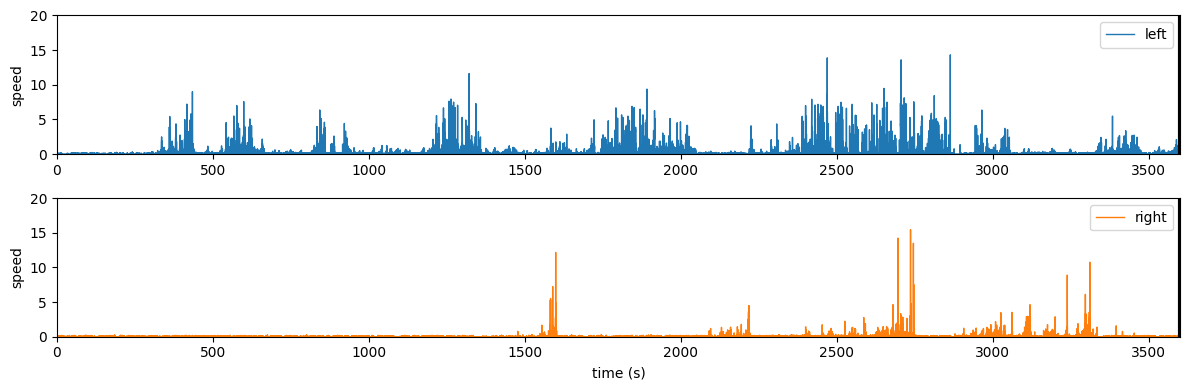

In [15]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=2)
axes[0].plot(t, l_spineM_speed, linewidth=1, label="left", color="tab:blue")
axes[1].plot(t, r_spineM_speed, linewidth=1, label="right", color="tab:orange")
for ax in axes:
    ax.axvline(3600, color="k", linewidth=3)
    ax.set_xlim([0, session_duration])
    ax.set_ylim([0, 20])
    ax.set_ylabel("speed")
    ax.legend()
axes[1].set_xlabel("time (s)")
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__speed.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()